In [5]:
import pandas as pd
from database.adatabase import ADatabase
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
from processor.processor import Processor as p
from asset.exposure import Exposure

In [6]:
sec = ADatabase("sec")
market = ADatabase("market")

In [7]:
market.connect()
index = market.retrieve("sp500")
market.disconnect()
factors = ["assets","liabilities","adjclose"]


In [8]:
market.connect()
sec.connect()
factors_df = []
for row in tqdm(index.iterrows()):
    try:
        ticker = row[1]["ticker"]
        cik = int(row[1]["CIK"])
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date")
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        filings = p.column_date_processing(sec.query("filings",{"cik":cik}))
        filings["year"] = filings["year"] + 1
        # filings["year"] = [x.year if x.quarter < 4 else x.year + 1 for x in filings["date"]]
        # filings["quarter"] = [x.quarter + 1 if x.quarter < 4 else 1 for x in filings["date"]]
        price = price.drop(["date","ticker"],axis=1).merge(filings.drop(["date","cik"],axis=1),on=["year","quarter"],how="left").groupby(["year","quarter"]).mean().reset_index()
        price["ticker"] = ticker
        price["y"] = price["adjclose"].shift(-1)
        factors_df.append(price[["year","quarter","ticker","y"]+factors])
    except Exception as e:
        print(ticker,str(e))
        continue
sec.disconnect()
market.disconnect()
factors_df = pd.concat(factors_df).sort_values(["year","quarter"])

27it [00:01, 22.02it/s]

AMTM 'date'


62it [00:03, 21.83it/s]

BRK.B 'date'


68it [00:03, 20.26it/s]

BLK 'date'


77it [00:04, 18.58it/s]

BF.B 'date'


502it [00:26, 18.84it/s]

ZTS 'date'


In [9]:
model = XGBRegressor()
training_data = factors_df[(factors_df["year"]>=2013) & (factors_df["year"]<2020)]
sim = factors_df[(factors_df["year"]>=2019)]
model.fit(training_data[factors],training_data["y"])
sim["prediction"] = model.predict(sim[factors])

C:\Users\eric\AppData\Local\Temp\ipykernel_13112\4077087314.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim["prediction"] = model.predict(sim[factors])


In [10]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]):
    try:
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        price.sort_values("date",inplace=True)
        price = price.merge(sim[["year","quarter","ticker","prediction"]],on=["year","quarter","ticker"],how="left")
        prices.append(price)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

 12%|██████████████████▉                                                                                                                                      | 62/502 [00:03<00:19, 22.01it/s]

'date'


 16%|███████████████████████▊                                                                                                                                 | 78/502 [00:03<00:19, 21.66it/s]

'date'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502/502 [00:26<00:00, 19.12it/s]

'date'


In [24]:
simulation = pd.concat(prices).dropna()

In [25]:
tickers = list(simulation[simulation["year"]==2020]["ticker"].unique())
simulation = simulation[simulation["ticker"].isin(tickers)]

In [26]:
simulation["factor"] = simulation["prediction"]/simulation["adjclose"] - 1

In [27]:
simulation["rank"] = simulation.groupby(["date"])["factor"].rank(method="dense",ascending=False).astype(int)

In [28]:
simulation["exposure"] = [1 if x <= simulation["rank"].max() * 0.50 else -1 if x > simulation["rank"].max() * 0.50 else 1.0/6.0 for x in simulation["rank"]]

In [29]:
weight = 1 / len(tickers)

In [30]:
simulation["sell_price"] = simulation["adjclose"]
simulation.sort_values("date",inplace=True)
trades = simulation[simulation["year"]>=2020][["year","quarter","ticker","exposure","adjclose","sell_price"]].groupby(["year","quarter","ticker"]).agg({"exposure":"first","adjclose":"first","sell_price":"last"}).reset_index()
trades["return"] = (trades["sell_price"] - trades["adjclose"])/trades["adjclose"]
trades["return"] = trades["return"] * trades["exposure"] * weight
analysis = trades[["year","quarter","exposure","return"]].groupby(["year","quarter","exposure"]).sum().pivot_table(index=["year","quarter"],columns="exposure",values="return").reset_index()

In [31]:
trades.sort_values("return",ascending=False).head(40)

,year,quarter,ticker,exposure,adjclose,sell_price,return
8235,2024,1,SMCI,1,28.545000,101.003000,0.005180
920,2020,2,TRGP,1,5.347719,18.362795,0.004967
605,2020,2,CZR,1,11.690000,40.060000,0.004953
522,2020,2,APA,1,3.677635,12.386293,0.004833
1828,2020,4,PLTR,1,9.460000,23.550000,0.003040
925,2020,2,TSLA,1,32.104000,71.987333,0.002535
6765,2023,2,SMCI,1,11.272000,24.925000,0.002472
9668,2024,4,PLTR,1,36.460000,80.550000,0.002468
798,2020,2,MRNA,1,29.670000,64.210000,0.002376
2385,2021,1,TPL,1,238.723286,502.674591,0.002256


In [32]:
trades.iloc[-505:].to_csv("current.csv")

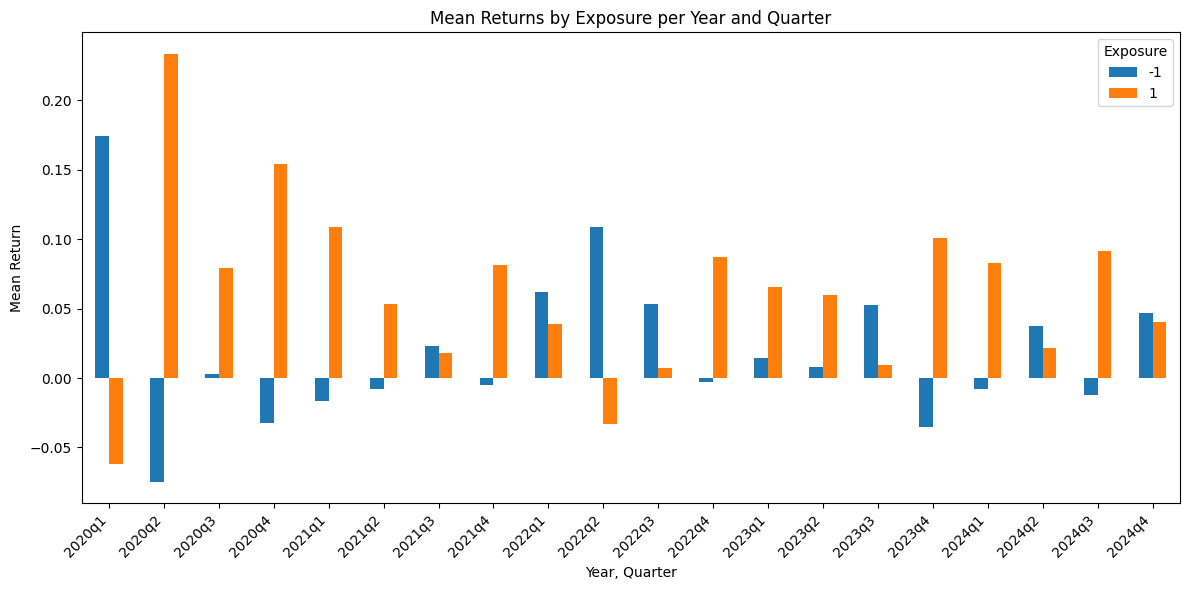

In [33]:
analysis['Year-Quarter'] = analysis["year"].astype(str) + "q" + analysis["quarter"].astype(str)

# Reset index for plotting
analysis.drop(["year","quarter"],axis=1,inplace=True)
analysis.reset_index(drop=True, inplace=True)

# Plot a bar chart
analysis.set_index("Year-Quarter").plot(
    kind="bar",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Customize the plot
plt.xlabel("Year, Quarter")
plt.ylabel("Mean Return")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title="Exposure")
plt.tight_layout()

# Show the plot
plt.show()


In [34]:
portfolio = trades[["year","quarter","return"]].groupby(["year","quarter"]).sum().reset_index()
portfolio["return"] = portfolio["return"] + 1
portfolio["return"] = portfolio["return"].cumprod()

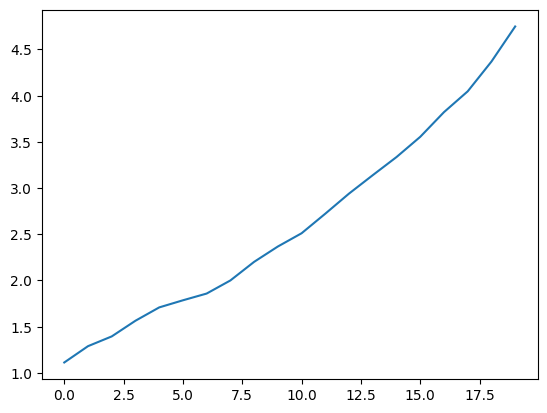

In [35]:
plt.plot(portfolio.index,portfolio["return"])

In [40]:
trades.merge(index,on=["ticker"],how="left")[["year","quarter","GICS Sector","return"]].groupby(["year","quarter","GICS Sector"]).sum().tail(20)

return
year quarter GICS Sector                     
2024 3       Consumer Staples        0.007243
             Energy                  0.002989
             Financials              0.012215
             Health Care             0.010095
             Industrials             0.011942
             Information Technology  0.008734
             Materials               0.003251
             Real Estate             0.007756
             Utilities               0.009316
     4       Communication Services  0.003772
             Consumer Discretionary  0.013476
             Consumer Staples        0.003950
             Energy                  0.004831
             Financials              0.009413
             Health Care             0.011665
             Industrials             0.010692
             Information Technology  0.014183
             Materials               0.006178
             Real Estate             0.004225
             Utilities               0.004505